## Reward computation

### Check wheter expected interaction reward matches with environment reward

In [21]:
import json
from Environment import Environment
from Model.Evaluator.GraphEvaluator import GraphEvaluator
from Model.Evaluator.Baseline import Baseline
from Model.Evaluator.OneStepEvaluator import OneStepEvaluator

from Model.Product import *
import numpy as np

# ==== PARAMETERS TO CHANGE ====
config_path = "./Configs/config2.json"
RANDOM_ARM = True
arm = [1, 1, 1, 1, 1]
n_experiments = 500
# ==============================

f = open(config_path)
config = json.load(f)
f.close()

env = Environment(config_path=config_path)
marginsPerPrice = config["margins"]

if RANDOM_ARM:
    arm = np.floor(np.random.rand(len(marginsPerPrice)) * len(marginsPerPrice[0]))
    arm = np.array(arm.tolist(), dtype=int)

margins = [marginsPerPrice[i][arm[i]] for i in range(0,len(arm))]
# print(margins)
obtained_margins = []

conf_classes = config["classes"]
user_means = []
evaluators = []
for uc in conf_classes:
    armConvRates = [uc["conversionRates"][i][arm[i]] for i in range(0,len(arm))]
    productList = [Product(int(key), uc["secondary"][key]) for key in uc["secondary"]]
    eval = GraphEvaluator(products_list=productList, click_prob_matrix=uc["clickProbability"], lambda_prob=uc["lambda"], conversion_rates=armConvRates,
                alphas=uc["alphas"], margins=margins, units_mean=uc["unitsShape"], convert_units=True, verbose=False)
    baseline = Baseline(products_list=productList, click_prob_matrix=uc["clickProbability"], lambda_prob=uc["lambda"], conversion_rates=armConvRates,
                alphas=uc["alphas"], margins=margins, units_mean=uc["unitsShape"], convert_units=True, verbose=False)
    oneStep = OneStepEvaluator(products_list=productList, click_prob_matrix=uc["clickProbability"], lambda_prob=uc["lambda"], conversion_rates=armConvRates,
                alphas=uc["alphas"], margins=margins, units_mean=uc["unitsShape"], verbose=False)
    evaluators.append((eval,baseline,oneStep))
    user_means.append(uc["usersMean"])
user_means = np.array(user_means)

env.setPriceLevels(arm)
for i in range(0,n_experiments):
  inters = env.round()
  total = 0
  for inter in inters:
    total += inter.linearizeMargin(marginsPerPrice)
    obtained_margins.append(inter.linearizeMargin(marginsPerPrice))
  total = total / len(inters)
  # obtained_margins.append(total)

print("SINGLE ITERATION/SESSION REWARDS FOR CONFIG {}:".format(arm))
print("   - [EMPIRICAL] Mean reward ({} experiments from env): {}\n".format(n_experiments, np.array(obtained_margins).mean()))

i = 0
ge_margins = []
for ev_group in evaluators:
  ge_result = ev_group[0].computeMargin()
  ge_margins.append(ge_result)
  print("   - [THEORY CLASS {}] Graph expected reward: {}".format(i, ge_result))
  print("   - [THEORY CLASS {}] Baseline expected reward: {}".format(i, ev_group[1].computeMargin()))
  print("   - [THEORY CLASS {}] One-Step expected reward: {}\n".format(i, ev_group[2].computeMargin()))
  i += 1

print("   - [THEORETICAL] Graph expected reward weighted by {}: {}".format(user_means, np.multiply(user_means, ge_margins).sum() / user_means.sum() ))



SINGLE ITERATION/SESSION REWARDS FOR CONFIG [0 1 2 3 1]:
   - [EMPIRICAL] Mean reward (500 experiments from env): 8.250265764001567

   - [THEORY CLASS 0] Graph expected reward: 7.1512899999999995
   - [THEORY CLASS 0] Baseline expected reward: 7.1512899999999995
   - [THEORY CLASS 0] One-Step expected reward: 6.43

   - [THEORY CLASS 1] Graph expected reward: 8.094100000000001
   - [THEORY CLASS 1] Baseline expected reward: 8.094100000000001
   - [THEORY CLASS 1] One-Step expected reward: 7.4

   - [THEORY CLASS 2] Graph expected reward: 11.696
   - [THEORY CLASS 2] Baseline expected reward: 11.696
   - [THEORY CLASS 2] One-Step expected reward: 11.0

   - [THEORETICAL] Graph expected reward weighted by [30 30 10]: 8.204595714285716


### Class for config evaluation

In [28]:
import json
from Environment import Environment
from Model.Evaluator.MultiClassEvaluator import MultiClassEvaluator
from Model.Product import *
import numpy as np

# ==== PARAMETERS TO CHANGE ====
config_path = "./Configs/config3.json"
RANDOM_ARM = True
arm = [1, 1, 1, 1, 1]
n_experiments = 500
# ==============================

NUM_PRODS = len(arm)
mce = MultiClassEvaluator(config_path=config_path)

f = open(config_path)
config = json.load(f)
f.close()

env = Environment(config_path=config_path)
marginsPerPrice = config["margins"]
NUM_PRODS = len(marginsPerPrice)
NUM_PRICES = len(marginsPerPrice[0])


if RANDOM_ARM:
    arm = np.floor(np.random.rand(NUM_PRODS) * NUM_PRICES)
    arm = np.array(arm.tolist(), dtype=int)

env.setPriceLevels(arm)
obtained_margins = []
for i in range(0,n_experiments):
  inters = env.round()
  total = 0
  for inter in inters:
    total += inter.linearizeMargin(marginsPerPrice)
    obtained_margins.append(inter.linearizeMargin(marginsPerPrice))
  total = total / len(inters)
  # obtained_margins.append(total)

print("SINGLE ITERATION/SESSION REWARDS FOR CONFIG {}:".format(arm))
print("   - [EMPIRICAL] Mean reward ({} experiments from env): {}\n".format(n_experiments, np.array(obtained_margins).mean()))
print("   - [THEORETICAL] Graph expected reward weighted by MultiClassEvaluator: {}".format(mce.computeMargin(arm)))



SINGLE ITERATION/SESSION REWARDS FOR CONFIG [3 0 0 3 3]:
   - [EMPIRICAL] Mean reward (500 experiments from env): 9.200748791595652

   - [THEORETICAL] Graph expected reward weighted by MultiClassEvaluator: 9.274597218033097


### Average distance from Environment data and GraphEvaluator

In [14]:
import json
from Environment import Environment
from Model.Evaluator.GraphEvaluator import GraphEvaluator
from Model.Evaluator.Baseline import Baseline
from Model.Evaluator.OneStepEvaluator import OneStepEvaluator
from Learner.BruteForce import *
from Model.Product import *
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output

# ==== PARAMETERS TO CHANGE ====
config_path = "./Configs/config3.json"
RANDOM_ARM = False
n_experiments = 100
# ==============================

f = open(config_path)
config = json.load(f)
f.close()

user_means = []
conf_classes = config["classes"]
for uc in conf_classes:
  user_means.append(uc["usersMean"])
class_weights = np.array(user_means) / np.array(user_means).sum()

env = Environment(config_path=config_path)
marginsPerPrice = config["margins"]
num_prods = len(config["margins"])
num_prices = len(config["margins"][0])

evaluatorEnvDifference = []
bf = BruteForce(num_prices=num_prices, num_products=num_prods)
for i in tqdm(range(0, num_prices**num_prods)):
  arm = bf.pull_arm() 
  margins = [marginsPerPrice[i][arm[i]] for i in range(0,len(arm))]
  # print(margins)
  obtained_margins = []

  conf_classes = config["classes"]
  evaluators_rews = []
  for uc in conf_classes:
      armConvRates = [uc["conversionRates"][i][arm[i]] for i in range(0,len(arm))]
      productList = [Product(int(key), uc["secondary"][key]) for key in uc["secondary"]]
      eval = GraphEvaluator(products_list=productList, click_prob_matrix=uc["clickProbability"], lambda_prob=uc["lambda"], conversion_rates=armConvRates,
                  alphas=uc["alphas"], margins=margins, units_mean=uc["actualUnitsMean"], convert_units=False, verbose=False)
      evaluators_rews.append(eval.computeMargin())
      baseline = Baseline(products_list=productList, click_prob_matrix=uc["clickProbability"], lambda_prob=uc["lambda"], conversion_rates=armConvRates,
                  alphas=uc["alphas"], margins=margins, units_mean=uc["actualUnitsMean"], convert_units=False, verbose=False)
      oneStep = OneStepEvaluator(products_list=productList, click_prob_matrix=uc["clickProbability"], lambda_prob=uc["lambda"], conversion_rates=armConvRates,
                  alphas=uc["alphas"], margins=margins, units_mean=uc["actualUnitsMean"], verbose=False)

  env.setPriceLevels(arm)
  for i in range(0,n_experiments):
    inters = env.round()
    total = 0
    for inter in inters:
      total += inter.linearizeMargin(marginsPerPrice)
      obtained_margins.append(inter.linearizeMargin(marginsPerPrice))
    total = total / len(inters)
  
  environmentMean = np.array(obtained_margins).mean()
  evaluatorMeanByClass = np.multiply(evaluators_rews, class_weights).sum()
  # Percentage error of graph eval from environment
  evaluatorEnvDifference.append(abs(environmentMean - evaluatorMeanByClass) / environmentMean)

clear_output(wait=True)
evaluatorEnvDifference = np.array(evaluatorEnvDifference)
print("PERCENTAGE ERROR OF GRAPH EVALUATOR FROM ENVIRONMENT ({}):".format(config_path))
print("   - [MEAN] {}".format(evaluatorEnvDifference.mean()))
print("   - [STD] {}".format(evaluatorEnvDifference.std()))
print("   - [MAX] {}".format(evaluatorEnvDifference.max()))
print("   - [MIN] {}".format(evaluatorEnvDifference.min()))


PERCENTAGE ERROR OF GRAPH EVALUATOR FROM ENVIRONMENT (./Configs/config3.json):
   - [MEAN] 0.0208341907010427
   - [STD] 0.016339860922586425
   - [MAX] 0.10378701842985763
   - [MIN] 1.9434061694763793e-05


## Visiting probability computation

### Graph Evaluator vs Environment visiting probability

In [15]:
import json
from Environment import Environment
from Model.Evaluator.GraphEvaluator import GraphEvaluator
from Model.Evaluator.Baseline import Baseline
from Model.Evaluator.OneStepEvaluator import OneStepEvaluator
from Learner.BruteForce import *
from Model.Product import *
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output

# ==== PARAMETERS TO CHANGE ====
config_path = "./Configs/config3.json"
RANDOM_ARM = True
arm = [0, 0, 0, 0, 0]
n_experiments = 250
# ==============================

f = open(config_path)
config = json.load(f)
f.close()

env = Environment(config_path=config_path)
marginsPerPrice = config["margins"]
num_prods = len(config["margins"])
num_prices = len(config["margins"][0])

if RANDOM_ARM:
    arm = np.floor(np.random.rand(len(marginsPerPrice)) * len(marginsPerPrice[0]))
    arm = np.array(arm.tolist(), dtype=int)
env.setPriceLevels(arm)

cumulative_visits = np.zeros(num_prods)
cumulative_interactions = 0
for i in tqdm(range(0,n_experiments)):
    interactions = env.round()
    cumulative_interactions += len(interactions)
    for inter in interactions:
        cumulative_visits = cumulative_visits + inter.linearizeVisits()
clear_output(wait=True)

environment_probs = cumulative_visits / cumulative_interactions
print("DIFFERENCE FROM ENVIRONMENT AND GE VISITING PROBABILITY, ARM {} ({}):".format(arm, config_path))
print("   - [ENV] {}".format(environment_probs))


for j in range(0,num_prods):
    for k in range(0,len(config["classes"])):
        env.classes[k].alphas = np.full(num_prods, 0.000001).tolist()
        env.classes[k].alphas[j] = 1.00004
    cumulative_visits = np.zeros(num_prods)
    cumulative_interactions = 0
    for i in range(0,n_experiments):
        interactions = env.round()
        cumulative_interactions += len(interactions)
        for inter in interactions:
            cumulative_visits = cumulative_visits + inter.linearizeVisits()
    print("      - [STARTING {}] {}".format(j, cumulative_visits / cumulative_interactions))
print("")
conf_classes = config["classes"]
i = 0
weighted_classes = np.zeros((num_prods))
tot_users_daily = 0
for uc in conf_classes:
    armConvRates = [uc["conversionRates"][i][arm[i]] for i in range(0,len(arm))]
    productList = [Product(int(key), uc["secondary"][key]) for key in uc["secondary"]]
    eval = GraphEvaluator(products_list=productList, click_prob_matrix=uc["clickProbability"], lambda_prob=uc["lambda"], conversion_rates=armConvRates,
                alphas=uc["alphas"], margins=marginsPerPrice, units_mean=uc["actualUnitsMean"], convert_units=False, verbose=False)
    visit_prob = eval.getVisitingProbability()
    weighted_classes = weighted_classes + visit_prob * uc["usersMean"]
    tot_users_daily += uc["usersMean"]
    print("   - [G/E CLASS {}] {}".format(i, visit_prob))
    for k in range(0,num_prods):
        print("      - [STARTING {}] {}".format(k, eval.computeSingleProduct(k)))
    i += 1

print("")
ge_weighted_probs = weighted_classes / tot_users_daily
print("   - [G/E TOTAL] {}\n".format(ge_weighted_probs))

print("PERFORMANCE INDEX => {} => {}".format(np.abs(ge_weighted_probs - environment_probs), np.abs(ge_weighted_probs - environment_probs).mean()))



DIFFERENCE FROM ENVIRONMENT AND GE VISITING PROBABILITY, ARM [3 0 3 1 1] (./Configs/config3.json):
   - [ENV] [0.30884901 0.36340768 0.32757561 0.2032534  0.225334  ]
      - [STARTING 0] [1.         0.06621221 0.07291725 0.00502878 0.0101693 ]
      - [STARTING 1] [0.00727802 1.         0.29067294 0.03459859 0.1231665 ]
      - [STARTING 2] [0.01129944 0.02522795 1.         0.04609274 0.03753426]
      - [STARTING 3] [0.21655659 0.15481921 0.06039404 1.         0.22428076]
      - [STARTING 4] [0.03905066 0.64893677 0.18880099 0.1827414  1.        ]

   - [G/E CLASS 0] [0.50951586 0.44942762 0.18946036 0.05136863 0.08975355]
      - [STARTING 0] [1.         0.05103401 0.061328   0.00370889 0.00782575]
      - [STARTING 1] [0.0060145  1.         0.28012485 0.03129359 0.12093545]
      - [STARTING 2] [0.00857623 0.02301244 1.         0.04451584 0.03581747]
      - [STARTING 3] [0.192      0.13574053 0.04683409 1.         0.20112673]
      - [STARTING 4] [0.03356705 0.63059674 0.17804652

### Graph vs Environment visiting probability total performance

In [10]:
import json
from Environment import Environment
from Model.Evaluator.GraphEvaluator import GraphEvaluator
from Model.Evaluator.Baseline import Baseline
from Model.Evaluator.OneStepEvaluator import OneStepEvaluator
from Learner.BruteForce import *
from Model.Product import *
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output

# ==== PARAMETERS TO CHANGE ====
config_path = "./Configs/config3.json"
n_experiments = 100
# ==============================

f = open(config_path)
config = json.load(f)
f.close()

env = Environment(config_path=config_path)
marginsPerPrice = config["margins"]
num_prods = len(config["margins"])
num_prices = len(config["margins"][0])

distances_index = []
for i in tqdm(range(0, num_prices**num_prods)):
    arm = bf.pull_arm() 
    env.setPriceLevels(arm)

    cumulative_visits = np.zeros(num_prods)
    cumulative_interactions = 0
    for i in range(0,n_experiments):
        interactions = env.round()
        cumulative_interactions += len(interactions)
        for inter in interactions:
            cumulative_visits = cumulative_visits + inter.linearizeVisits()
    

    environment_probs = cumulative_visits / cumulative_interactions

    conf_classes = config["classes"]
    i = 0
    weighted_classes = np.zeros((num_prods))
    tot_users_daily = 0
    for uc in conf_classes:
        armConvRates = [uc["conversionRates"][i][arm[i]] for i in range(0,len(arm))]
        productList = [Product(int(key), uc["secondary"][key]) for key in uc["secondary"]]
        eval = GraphEvaluator(products_list=productList, click_prob_matrix=uc["clickProbability"], lambda_prob=uc["lambda"], conversion_rates=armConvRates,
                    alphas=uc["alphas"], margins=marginsPerPrice, units_mean=uc["actualUnitsMean"], convert_units=False, verbose=False)
        visit_prob = eval.getVisitingProbability()
        weighted_classes = weighted_classes + visit_prob * uc["usersMean"]
        tot_users_daily += uc["usersMean"]
        i += 1

    ge_weighted_probs = weighted_classes / tot_users_daily

    distances_index.append(np.abs(ge_weighted_probs - environment_probs).mean())

clear_output(wait=True)
distances_index = np.array(distances_index)

print("MEAN ABSOLUTE ERROR OF VISITING PROBABILITY FROM GRAPH EVALUATOR TO ENVIRONMENT ({}):".format(config_path))
print("   - [MEAN] {}".format(distances_index.mean()))
print("   - [STD] {}".format(distances_index.std()))
print("   - [MAX] {}".format(distances_index.max()))
print("   - [MIN] {}".format(distances_index.min()))

MEAN ABSOLUTE ERROR FROM GRAPH EVALUATOR TO ENVIRONMENT (./Configs/config3.json):


AttributeError: 'list' object has no attribute 'mean'

In [11]:
distances_index = np.array(distances_index)

print("MEAN ABSOLUTE ERROR FROM GRAPH EVALUATOR TO ENVIRONMENT ({}):".format(config_path))
print("   - [MEAN] {}".format(distances_index.mean()))
print("   - [STD] {}".format(distances_index.std()))
print("   - [MAX] {}".format(distances_index.max()))
print("   - [MIN] {}".format(distances_index.min()))


MEAN ABSOLUTE ERROR FROM GRAPH EVALUATOR TO ENVIRONMENT (./Configs/config3.json):
   - [MEAN] 0.015544944923210742
   - [STD] 0.002981508112788395
   - [MAX] 0.026192905821785472
   - [MIN] 0.007054892092087162


## Configuration classes merge consistency check

In [4]:
from Model.ConfigurationParametersAverage import mergeUserClasses
from Environment import Environment
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output

# ==== PARAMETERS TO CHANGE ====
CONFIG_PATH = './Configs/configuration4.json'
n_experiments = 250
# ==============================

env = Environment(config_path=CONFIG_PATH)

config = mergeUserClasses([CONFIG_PATH], False)[0]
l = config["lambda_p"]

env.setPriceLevels([0,1,3,1,0])
total_inters = 0
total_starting = np.full(5,0)
total_bought = np.full(5,0)
total_units = np.full(5,0)
total_visits = np.full(5,0)
for i in range(0,n_experiments):
    inters = env.round()
    total_inters += len(inters)
    for inter in inters:
        total_starting = np.add(inter.linearizeStart(), total_starting)
        total_bought = np.add(inter.linearizeBought(), total_bought)
        total_units = np.add(inter.linearizeNumUnits(), total_units)
        total_visits = np.add(inter.linearizeVisits(), total_visits)

print("MERGE USER CLASSES CHECK ({}):".format(CONFIG_PATH))
print("   - [ALPHA ACTUAL] {} ".format(total_starting / total_inters))
print("   - [ALPHA DERIVED] {} ".format(config["alphas"]))
print("   - [ALPHA PERFORMANCE] {} \n".format(np.abs(np.subtract(total_starting / total_inters, config["alphas"])).mean()))

print("   - [UNITS ACTUAL] {} ".format(total_units / total_bought))
print("   - [UNITS DERIVED] {} ".format(config["actual_units_mean"]))
print("   - [UNITS PERFORMANCE] {} \n".format(np.abs(np.subtract(total_units / total_bought, config["actual_units_mean"])).mean()))

conv_rates = np.full((5,4),0, dtype=float)
for k in range(0,4):
    env.setPriceLevels(np.full(5,k).tolist())

    total_bought = np.full(5,0)
    total_visits = np.full(5,0)
    for i in range(0,n_experiments):
        inters = env.round()
        total_inters += len(inters)
        for inter in inters:
            total_bought = np.add(inter.linearizeBought(), total_bought)
            total_visits = np.add(inter.linearizeVisits(), total_visits)
    
    curr_rates = total_bought / total_visits
    # print(curr_rates)
    for i in range(0,len(curr_rates)):
        conv_rates[i][k] = curr_rates[i]


print("   - [CONV RATES ACTUAL] {} ".format(np.round(conv_rates, decimals=2)))
print("   - [CONV RATES DERIVED] {} ".format(np.round(config["conversionRateLevels"], decimals=2)))
print("   - [CONV RATES PERFORMANCE] {} \n".format(np.abs(np.subtract(conv_rates, config["conversionRateLevels"])).mean()))

interactions = []
env.setPriceLevels([0,1,3,1,0])
for i in range(0,n_experiments):
    interactions = interactions + env.round()
secondary = config["productList"]
sec_prods = []
for p in secondary:
    sec_prods.append([p.getSecondaryProduct(0), p.getSecondaryProduct(1)])
clickProbability = np.zeros((5,5))
openedFirst = np.zeros(5)
openedSecond = np.zeros(5)
trialFirst = np.zeros(5)
trialSecond = np.zeros(5)

single_interactions_list = []
for inter in interactions:
    single_interactions_list.append(inter)
    trialFirst = np.add(trialFirst, inter.linearizeOpenedFirstTrial())
    trialSecond = np.add(trialSecond, inter.linearizeOpenedSecondTrial())

while len(single_interactions_list) > 0:
    p = single_interactions_list.pop()
    openedFirst[p.product] += p.sec1Opened
    openedSecond[p.product] += p.sec2Opened
    # expand
    for j in range(0, len(p.following)):
        single_interactions_list.append(p.following[j])

for i in range(0,5):
    if trialFirst[i] > 0:
        clickProbability[i][sec_prods[i][0]] = openedFirst[i] / trialFirst[i]
    if trialSecond[i] > 0:
        clickProbability[i][sec_prods[i][1]] = openedSecond[i] / trialSecond[i]
        clickProbability[i][sec_prods[i][1]] = clickProbability[i][sec_prods[i][1]] / config["lambda_p"]

print("   - [CLICK PROB ESTIMATED 1] \n{} ".format(np.round(clickProbability, decimals=2)))
print("   - [CLICK PROB DERIVED] \n{} ".format(np.round(config["click_prob"], decimals=2)))


prob_seen_given_bought_inverted = np.zeros((5, 5), dtype=float)
        
for prod in config["productList"]:
    primary = prod.getProductNumber()
    sec_list = prod.getSecondaryProductList()
    prob_seen_given_bought_inverted[primary][sec_list[0]] = 1
    prob_seen_given_bought_inverted[primary][sec_list[1]] = 1 / l # this is lambda not one

opening_cumulative = np.zeros((5, 5), dtype=float)
max_possible_opening_cumulative = np.zeros((5, 5), dtype=float)
for inter in interactions:
    opening_cumulative = np.add(opening_cumulative, inter.linearizeSecondaryOpening())
    max_possible_opening_cumulative = np.add(max_possible_opening_cumulative, inter.linearizePossibleSecondaryOpening())

opening_prob_given_bought = np.divide(opening_cumulative, max_possible_opening_cumulative, 
                        out=np.full_like(opening_cumulative, 0), where=max_possible_opening_cumulative!=0)
        
opening_prob_given_seen = opening_prob_given_bought * prob_seen_given_bought_inverted
print("   - [CLICK PROB ESTIMATED 2] \n{}".format(np.round(opening_prob_given_seen, decimals=2)))
print("   - [CLICK PROB PERFORMANCE] {} ".format(np.abs(np.subtract(clickProbability, config["click_prob"])).mean()))

print("\n ", openedFirst)
print("", openedSecond)
print("", opening_cumulative)

print("\n ", trialFirst)
print("", trialSecond)
print("", max_possible_opening_cumulative)

MERGE USER CLASSES CHECK (./Configs/configuration4.json):
   - [ALPHA ACTUAL] [0.27127737 0.24172072 0.15929376 0.18431449 0.14339365] 
   - [ALPHA DERIVED] [0.275, 0.2375, 0.1625, 0.18125, 0.14375] 
   - [ALPHA PERFORMANCE] 0.002914085743549738 

   - [UNITS ACTUAL] [2.27701163 2.14639937 2.17684078 2.3994709  2.37880867] 
   - [UNITS DERIVED] [2.2713750000000004, 2.1505875000000003, 2.2167875, 2.426625, 2.3798625] 
   - [UNITS PERFORMANCE] 0.015595882232594694 

   - [CONV RATES ACTUAL] [[0.8  0.74 0.63 0.55]
 [0.81 0.68 0.59 0.54]
 [0.9  0.77 0.66 0.58]
 [0.71 0.66 0.61 0.54]
 [0.8  0.72 0.65 0.59]] 
   - [CONV RATES DERIVED] [[0.81 0.74 0.64 0.57]
 [0.8  0.68 0.58 0.54]
 [0.9  0.74 0.63 0.57]
 [0.74 0.67 0.61 0.54]
 [0.81 0.73 0.66 0.59]] 
   - [CONV RATES PERFORMANCE] 0.011568180815482798 

   - [CLICK PROB ESTIMATED 1] 
[[0.   0.58 0.   0.   0.7 ]
 [0.46 0.   0.   0.   0.35]
 [0.   0.   0.   0.72 0.66]
 [0.4  0.   0.87 0.   0.  ]
 [0.64 0.77 0.   0.   0.  ]] 
   - [CLICK PROB DER

## Configuration clairevoyancy

### Transforming units shape in units mean

In [35]:
from scipy.stats import gamma

units_mean = [0.94, 1.45, 1.2, 2.0, 1.5]
actual_means = []
for i in range(0,len(units_mean)):
    empiric_mean = np.ceil(np.random.gamma(units_mean[i], 1, size=1000000)).mean()
    actual_means.append(int(empiric_mean*10000) / 10000)
print("SHAPE TRANSFORMATION:")
print("   - [DISTRO] {}".format(units_mean))
print("   - [SAMPLING] {}".format(actual_means))

actual_means = []
for i in range(0,len(units_mean)):
    # empiric_mean = np.ceil(np.random.gamma(units_mean[i], 1, size=1000000)).mean()
    # New method using cumulative distribution, difference empiric and theoretic < 0.01
    significant = True
    theoretic_mean = 0
    num = 1
    while significant:
        t = (gamma.cdf(num, a=units_mean[i]) - gamma.cdf(num - 1, a=units_mean[i])) * num
        theoretic_mean += t
        num += 1
        if t < 0.01:
            significant = False
    #print(num)
    actual_means.append(int(theoretic_mean*10000) / 10000)
#print(actual_means)
units_mean = np.array(actual_means)
print("   - [GAMMA SCIPY] {}".format(actual_means))

SHAPE TRANSFORMATION:
   - [DISTRO] [0.94, 1.45, 1.2, 2.0, 1.5]
   - [SAMPLING] [1.5321, 1.9754, 1.7497, 2.504, 2.0233]
   - [GAMMA SCIPY] [1.527, 1.9716, 1.7454, 2.4968, 2.0175]


### Compute the best arm for each class by brute force

In [5]:
import json
from Environment import Environment
import numpy as np
from Learner.BruteForce import *
from Model.UserClass import *
from Model.Product import *
from Model.GraphProbabilities import *
from Model.Evaluator.GraphEvaluator import GraphEvaluator
from Model.Evaluator.Baseline import Baseline
from tqdm import tqdm
from IPython.display import clear_output



# ==== PARAMETERS TO CHANGE ====
CONFIG_PATH = './Configs/configuration6.json'
# ==============================


f = open(CONFIG_PATH)
config = json.load(f)
f.close()

opt_arms = []
opt_margins = []
daily_users = []
print("Starting the analysis ...\n")
for k in range(0, len(config["classes"])):
    uc = config["classes"][k]

    productList = [Product(int(key), uc["secondary"][key]) for key in uc["secondary"]]

    conversionRateLevels = uc["conversionRates"]
    marginsPerPrice = config["margins"]
    click_prob = np.array(uc["clickProbability"])
    lambda_p = uc["lambda"]
    alphas = uc["alphas"]
    units_mean = uc["actualUnitsMean"]
    # Early transform for efficiency reason
    # actual_means = []
    # for i in range(0,len(units_mean)):
    #    empiric_mean = np.ceil(np.random.gamma(units_mean[i], 1, size=1000000)).mean()
    #     actual_means.append(int(empiric_mean*100) / 100)
    # units_mean = actual_means

    daily_users.append(uc["usersMean"])
    num_prices = len(conversionRateLevels[0])
    num_prods = len(alphas)

    print("Brute forcing class {}".format(k))
    bf = BruteForce(num_prices=num_prices, num_products=num_prods)
    for i in tqdm(range(0, num_prices**num_prods)):
        pulledArm = bf.pull_arm()
        margins = []
        convRates = []
        for k in range(0,len(pulledArm)):
            margins.append(marginsPerPrice[k][pulledArm[k]])
            convRates.append(conversionRateLevels[k][pulledArm[k]])

        price_configuration_margin = 0
        eval = GraphEvaluator(products_list=productList, click_prob_matrix=click_prob, lambda_prob=lambda_p, conversion_rates=convRates,
                        alphas=alphas, margins=margins, units_mean=units_mean, convert_units=False, verbose=False)
        eval2 = Baseline(products_list=productList, click_prob_matrix=click_prob, lambda_prob=lambda_p, conversion_rates=convRates,
                        alphas=alphas, margins=margins, units_mean=units_mean, convert_units=False, verbose=False)

        overall_margin = eval.computeMargin()
        baseline = eval2.computeMargin()
        # print("Configuration {}; ConvRates {}; Margins {}; Overall Margin {}; Baseline {}".format(pulledArm,convRates,margins,int(overall_margin*100)/100,int(baseline*100)/100))
        # if overall_margin < baseline:
            # print("VAFFANCULOOOOO {} - {} = {}".format(overall_margin,baseline,overall_margin-baseline))
        bf.update(overall_margin)

    opt_arms.append(bf.get_optima())
    opt_margins.append(bf.get_optima_margin())
clear_output(wait=True)
print("BRUTE FORCE OF CONFIG {} CLASSES:".format(CONFIG_PATH))
for i in range(0,len(opt_arms)):
    print("   - [CLASS {}] Optimal arm is {} with margin {}".format(i,opt_arms[i], opt_margins[i]))

daily_users = np.array(daily_users)
classes_weights = daily_users / daily_users.sum()
opt_margins = np.array(opt_margins)
print("\nThe optimal weighted mean expected margin given the mean daily users {} is {}".format(daily_users, np.multiply(classes_weights, opt_margins).sum()))

# Best single arm possible
print("\nWhich arm among the best ones gives the better results in non contextual optmization?")
equal_arm_rew = []
for i in range(0,len(opt_arms)):
    arm = opt_arms[i]
    class_rewards = []
    for k in range(0, len(config["classes"])):
        uc = config["classes"][k]
        productList = [Product(int(key), uc["secondary"][key]) for key in uc["secondary"]]
        conversionRateLevels = uc["conversionRates"]
        marginsPerPrice = config["margins"]
        click_prob = np.array(uc["clickProbability"])
        lambda_p = uc["lambda"]
        alphas = uc["alphas"]
        units_mean = uc["unitsShape"]
        num_prices = len(conversionRateLevels[0])
        num_prods = len(alphas)

        pulledArm = arm
        margins = []
        convRates = []
        for k in range(0,len(pulledArm)):
            margins.append(marginsPerPrice[k][pulledArm[k]])
            convRates.append(conversionRateLevels[k][pulledArm[k]])

        eval = GraphEvaluator(products_list=productList, click_prob_matrix=click_prob, lambda_prob=lambda_p, conversion_rates=convRates,
                        alphas=alphas, margins=margins, units_mean=units_mean, verbose=False)
        eval2 = Baseline(products_list=productList, click_prob_matrix=click_prob, lambda_prob=lambda_p, conversion_rates=convRates,
                        alphas=alphas, margins=margins, units_mean=units_mean, verbose=False)
                    
        class_rewards.append(eval.computeMargin())
    
    weighted_reward = np.multiply(classes_weights, np.array(class_rewards)).sum()
    equal_arm_rew.append(weighted_reward)
    if class_rewards[i] < eval2.computeMargin():
        print("   - [ARM {}] Class-weighted expected margin is {}, but baseline is greater than weighted".format(arm, weighted_reward))
    else:
        print("   - [ARM {}] Class-weighted expected margin is {}".format(arm, weighted_reward))


user_means = []
conf_classes = config["classes"]
for uc in conf_classes:
  user_means.append(uc["usersMean"])
class_weights = np.array(user_means) / np.array(user_means).sum()

bf = BruteForce(num_prices=num_prices, num_products=num_prods)
for i in tqdm(range(0, num_prices**num_prods)):
    arm = bf.pull_arm() 
    margins = [marginsPerPrice[i][arm[i]] for i in range(0,len(arm))]

    obtained_margins = []

    conf_classes = config["classes"]
    evaluators_rews = []
    for uc in conf_classes:
        armConvRates = [uc["conversionRates"][i][arm[i]] for i in range(0,len(arm))]
        productList = [Product(int(key), uc["secondary"][key]) for key in uc["secondary"]]
        eval = GraphEvaluator(products_list=productList, click_prob_matrix=uc["clickProbability"], lambda_prob=uc["lambda"], conversion_rates=armConvRates,
                    alphas=uc["alphas"], margins=margins, units_mean=uc["actualUnitsMean"], convert_units=False, verbose=False)
        evaluators_rews.append(eval.computeMargin())    

    evaluatorMeanByClass = np.multiply(evaluators_rews, class_weights).sum()
    bf.update(evaluatorMeanByClass)

print("BRUTE FORCE BY WEIGHTING CLASSES REWARDS:".format(CONFIG_PATH))
print("   - [THEORY] Optimal arm is {} with margin {}".format(bf.get_optima(), bf.get_optima_margin()))


BRUTE FORCE OF CONFIG ./Configs/configuration6.json CLASSES:
   - [CLASS 0] Optimal arm is [3, 3, 3, 3, 3] with margin 86.4
   - [CLASS 1] Optimal arm is [0, 0, 0, 0, 0] with margin 2.1285000000000003
   - [CLASS 2] Optimal arm is [2, 2, 2, 2, 2] with margin 16.968000000000004

The optimal weighted mean expected margin given the mean daily users [10 40 25] is 18.3112

Which arm among the best ones gives the better results in non contextual optmization?
   - [ARM [3, 3, 3, 3, 3]] Class-weighted expected margin is 12.504166666666668
   - [ARM [0, 0, 0, 0, 0]] Class-weighted expected margin is 2.0019


  3%|▎         | 27/1024 [00:00<00:03, 262.09it/s]

   - [ARM [2, 2, 2, 2, 2]] Class-weighted expected margin is 8.590666666666667


100%|██████████| 1024/1024 [00:03<00:00, 273.71it/s]


BRUTE FORCE BY WEIGHTING CLASSES REWARDS:
   - [THEORY] Optimal arm is [3, 3, 3, 2, 3] with margin 14.373466666666669


### Compute best non stationary

In [7]:
import json
from Environment import Environment
import numpy as np
from Learner.BruteForce import *
from Model.UserClass import *
from Model.Product import *
from Model.GraphProbabilities import *
from Model.Evaluator.GraphEvaluator import GraphEvaluator
from Model.Evaluator.MultiClassEvaluator import MultiClassEvaluator
from Model.Evaluator.Baseline import Baseline
from tqdm import tqdm
from IPython.display import clear_output

# ==== PARAMETERS TO CHANGE ====
CONFIG_PATH = './Configs/ns_config3.json'
# ==============================


f = open(CONFIG_PATH)
config = json.load(f)
f.close()

num_prices = len(config["margins"][0])
num_prods = len(config["margins"])

# Computing when there will be some changes
opt_time_start = [0]
changes = []
for uc in config["classes"]:
    if "change" in uc:
        changes.append(uc["change"])
changes = sorted(changes, key=lambda x: x['step'])
for ch in changes:
    opt_time_start.append(ch["step"])


# Computing class weights
user_means = []
conf_classes = config["classes"]
for uc in conf_classes:
  user_means.append(uc["usersMean"])
class_weights = np.array(user_means) / np.array(user_means).sum()

# Compuring for each change the best by brute forcing
print("BRUTE FORCE BY WEIGHTING CLASSES REWARDS FOR EACH CHANGE:".format(CONFIG_PATH))
mce = MultiClassEvaluator(CONFIG_PATH)
for time in opt_time_start:
    bf = BruteForce(num_prices=num_prices, num_products=num_prods)
    for i in range(0, num_prices**num_prods):
        arm = bf.pull_arm() 

        weightedRewardAtTime = mce.computeMargin(arm, time=time)
        bf.update(weightedRewardAtTime)

    print("   - [TIME {}] Optimal arm is {} with margin {}".format(time, bf.get_optima(), bf.get_optima_margin()))

BRUTE FORCE BY WEIGHTING CLASSES REWARDS FOR EACH CHANGE:
   - [TIME 0] Optimal arm is [2, 2, 0, 2, 0] with margin 58.14556075422261
   - [TIME 270] Optimal arm is [0, 2, 0, 1, 0] with margin 46.34123464913213


### Results analyzer and plotter

['NS-UCB_CD_2022-07-14_15-41_ns_config1.json', 'NS-UCB_CD_2022-07-14_15-41_ns_config2.json', 'NS-UCB_CD_2022-07-14_15-41_ns_config3.json', 'NS-UCB_CD_2022-07-14_15-41_ns_config5.json', 'NS-UCB_SW_2022-07-14_17-08_ns_config1.json', 'NS-UCB_SW_2022-07-14_17-08_ns_config2.json', 'NS-UCB_SW_2022-07-14_17-08_ns_config3.json', 'NS-UCB_SW_2022-07-14_17-08_ns_config5.json', 'NS-UCB_SW_2022-07-14_18-22_ns_config1.json', 'NS-UCB_T_2022_Config1.json', 'TS_Alphas_2022-07-14_16-25_config1.json', 'TS_Alphas_2022-07-14_16-25_config2.json', 'TS_Alphas_2022-07-14_16-25_config3.json', 'TS_Alphas_2022-07-14_16-25_configuration4.json', 'TS_Alphas_2022-07-14_16-25_configuration5.json', 'TS_Alphas_2022-07-14_16-25_configuration6.json', 'TS_CR_2022-07-14_16-18_config1.json', 'TS_CR_2022-07-14_16-18_config2.json', 'TS_CR_2022-07-14_16-18_config3.json', 'TS_CR_2022-07-14_16-18_configuration4.json', 'TS_CR_2022-07-14_16-18_configuration5.json', 'TS_CR_2022-07-14_16-18_configuration6.json', 'TS_GW_2022-07-14_16-

(array([ 1.,  0.,  2.,  0.,  3., 10.,  8.,  6.,  3.,  3.,  3.,  1.]),
 array([52.35928748, 52.53725766, 52.71522784, 52.89319803, 53.07116821,
        53.24913839, 53.42710858, 53.60507876, 53.78304894, 53.96101913,
        54.13898931, 54.3169595 , 54.49492968]),
 <a list of 12 Patch objects>)

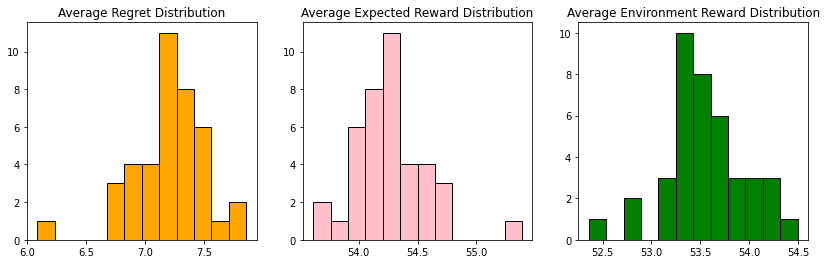

In [25]:
import json
from Environment import Environment
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir("./Results/") if isfile(join("./Results/", f))]
print(onlyfiles)
print("")

# ==== PARAMETERS TO CHANGE ====
RESULT_PATH = './Results/NS-UCB_SW_2022-07-14_17-08_ns_config1.json'
bins = 12
# ==============================


f = open(RESULT_PATH)
results = json.load(f)
f.close()


# matplotlib histogram
print("RESULTS FOR THE CONFIG OVER MULTIPLE RUNS {}".format(RESULT_PATH))
avgReg = np.array(results["averageRegrets"])
print("   - [AVG REGRET] Mean = {}, Std = {}".format(avgReg.mean(), avgReg.std()))
avgExpRew = np.array(results["averageExpectedRewards"])
print("   - [AVG EXP REW] Mean = {}, Std = {}".format(avgExpRew.mean(), avgExpRew.std()))
avgEnvRew = np.array(results["averageEnvRewards"])
print("   - [AVG ENV REW] Mean = {}, Std = {}".format(avgEnvRew.mean(), avgEnvRew.std()))

fig, axes = plt.subplots(ncols=3, nrows=1, sharex=False, figsize=(14,4))

axes[0].set_title("Average Regret Distribution")
axes[0].hist(results["averageRegrets"], color = 'orange', edgecolor = 'black', bins = bins)
axes[1].set_title("Average Expected Reward Distribution")
axes[1].hist(results["averageExpectedRewards"], color = 'pink', edgecolor = 'black', bins = bins)
axes[2].set_title("Average Environment Reward Distribution")
axes[2].hist(results["averageEnvRewards"], color = 'green', edgecolor = 'black', bins = bins)


### Results analyzer and plot comparison

['Contextual-ts_2022-07-14_20-40_config2.json', 'Contextual-ts_2022-07-14_20-40_config3.json', 'Contextual-ucb_2022-07-14_16-26_config2.json', 'Contextual-ucb_2022-07-14_16-26_config3.json', 'Contextual-ucb_2022-07-14_16-26_configuration4.json', 'Contextual-ucb_2022-07-14_16-26_configuration5.json', 'Contextual-ucb_2022-07-14_16-26_configuration6.json', 'NS-UCB_CD_2022-07-14_15-41_ns_config1.json', 'NS-UCB_CD_2022-07-14_15-41_ns_config2.json', 'NS-UCB_CD_2022-07-14_15-41_ns_config3.json', 'NS-UCB_CD_2022-07-14_15-41_ns_config5.json', 'NS-UCB_SW_2022-07-14_17-08_ns_config1.json', 'NS-UCB_SW_2022-07-14_17-08_ns_config2.json', 'NS-UCB_SW_2022-07-14_17-08_ns_config3.json', 'NS-UCB_SW_2022-07-14_17-08_ns_config5.json', 'NS-UCB_SW_2022-07-14_18-22_ns_config1.json', 'NS-UCB_T_2022_Config1.json', 'TS_Alphas_2022-07-14_16-25_config1.json', 'TS_Alphas_2022-07-14_16-25_config2.json', 'TS_Alphas_2022-07-14_16-25_config3.json', 'TS_Alphas_2022-07-14_16-25_configuration4.json', 'TS_Alphas_2022-07-14

(array([1., 1., 1., 5., 6., 9., 5., 6., 3., 1., 1., 1.]),
 array([ 9.74109515,  9.77813188,  9.8151686 ,  9.85220533,  9.88924205,
         9.92627878,  9.9633155 , 10.00035223, 10.03738895, 10.07442567,
        10.1114624 , 10.14849912, 10.18553585]),
 <a list of 12 Patch objects>)

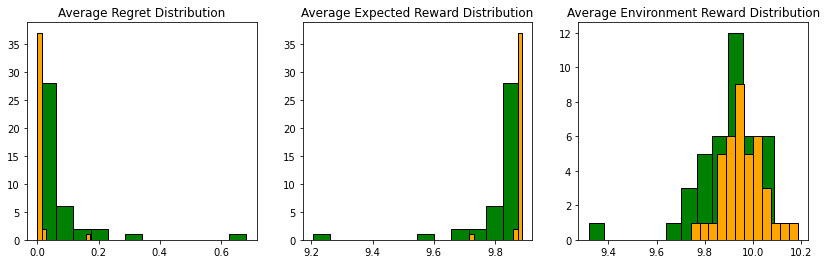

In [6]:
import json
from Environment import Environment
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir("./Results/") if isfile(join("./Results/", f))]
print(onlyfiles)
print("")

# ==== PARAMETERS TO CHANGE ====
RESULT_PATH_2 = './Results/TS_CR_2022-07-14_16-18_config2.json'
RESULT_PATH_1 = './Results/UCB_Step3_2022-07-14_16-23_config2.json'
bins = 12
# ==============================


f = open(RESULT_PATH_1)
results1 = json.load(f)
f.close()

f = open(RESULT_PATH_2)
results2 = json.load(f)
f.close()


# matplotlib histogram
print("RESULTS FOR THE CONFIG OVER MULTIPLE RUNS {}".format(RESULT_PATH_1))
avgReg = np.array(results1["averageRegrets"])
print("   - [AVG REGRET] Mean = {}, Std = {}".format(avgReg.mean(), avgReg.std()))
avgExpRew = np.array(results1["averageExpectedRewards"])
print("   - [AVG EXP REW] Mean = {}, Std = {}".format(avgExpRew.mean(), avgExpRew.std()))
avgEnvRew = np.array(results1["averageEnvRewards"])
print("   - [AVG ENV REW] Mean = {}, Std = {}\n".format(avgEnvRew.mean(), avgEnvRew.std()))

print("RESULTS FOR THE CONFIG OVER MULTIPLE RUNS {}".format(RESULT_PATH_2))
avgReg = np.array(results2["averageRegrets"])
print("   - [AVG REGRET] Mean = {}, Std = {}".format(avgReg.mean(), avgReg.std()))
avgExpRew = np.array(results2["averageExpectedRewards"])
print("   - [AVG EXP REW] Mean = {}, Std = {}".format(avgExpRew.mean(), avgExpRew.std()))
avgEnvRew = np.array(results2["averageEnvRewards"])
print("   - [AVG ENV REW] Mean = {}, Std = {}".format(avgEnvRew.mean(), avgEnvRew.std()))

fig, axes = plt.subplots(ncols=3, nrows=1, sharex=False, figsize=(14,4))

axes[0].set_title("Average Regret Distribution")
axes[0].hist(results1["averageRegrets"], color = 'green', edgecolor = 'black', bins = bins)
axes[0].hist(results2["averageRegrets"], color = 'orange', edgecolor = 'black', bins = bins)

axes[1].set_title("Average Expected Reward Distribution")
axes[1].hist(results1["averageExpectedRewards"], color = 'green', edgecolor = 'black', bins = bins)
axes[1].hist(results2["averageExpectedRewards"], color = 'orange', edgecolor = 'black', bins = bins)

axes[2].set_title("Average Environment Reward Distribution")
axes[2].hist(results1["averageEnvRewards"], color = 'green', edgecolor = 'black', bins = bins)
axes[2].hist(results2["averageEnvRewards"], color = 'orange', edgecolor = 'black', bins = bins)
